<a href="https://colab.research.google.com/github/jydiw/nyt-covid-19-data/blob/master/nyt_covid_data_county.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYTimes COVID-19 EDA and `pandas` Optimization

In [1]:
import numpy as np
import pandas as pd

from urllib.request import urlopen
import json

import itertools

from time import time
from datetime import datetime, timedelta

from shapely.geometry import Polygon

# import nytimes data

New York Times data has a few caveats, including treating New York City, Kansas City, and Joplin as single entities rather than including them in their respective counties. Read their [README](https://github.com/nytimes/covid-19-data/blob/master/README.md) for more information.

In [2]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = pd.read_csv(response)
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [3]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334375 entries, 0 to 334374
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    334375 non-null  object 
 1   county  334375 non-null  object 
 2   state   334375 non-null  object 
 3   fips    330965 non-null  float64
 4   cases   334375 non-null  int64  
 5   deaths  334375 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 15.3+ MB


In [4]:
for col in nyt_df.select_dtypes(include='object').columns:
    print(col)
    print(len(nyt_df[col].unique()))
    print()

date
176

county
1900

state
55



- `fips` should not be numeric. As we'll see down below, we will have to import this as an object type so that we don't convert `float` values to `str`.
- the max for both `cases` and `deaths` is well below the maximum value of `int64`, so we can downcast.
- by nature of the data, the `state`-`county` combinations (and therefore `fips`) are far fewer than the number of entries in our dataset. We can change `state`, `county`, and `fips` to the `category` data type.
- we should probably change `date` into a `datetime` data type. This gives us some flexibility later.

**Why `category`?** The memory of the `object` data type is proportional to its length, whereas for `category` it is proportional to the number of categories plus the length. Given that we have 300k+ rows and only 1814 unique counties, we save memory when converting that column to `category`.

https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#memory-usage

In [5]:
nyt_df['fips'] = nyt_df['fips'].astype('category')   # doesn't work as intended
nyt_df['cases'] = pd.to_numeric(nyt_df['cases'], downcast='integer')
nyt_df['deaths'] = pd.to_numeric(nyt_df['deaths'], downcast='integer')
nyt_df['state'] = nyt_df['state'].astype('category')
nyt_df['county'] = nyt_df['county'].astype('category')
nyt_df['date'] = pd.to_datetime(nyt_df['date'])
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [6]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334375 entries, 0 to 334374
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    334375 non-null  datetime64[ns]
 1   county  334375 non-null  category      
 2   state   334375 non-null  category      
 3   fips    330965 non-null  category      
 4   cases   334375 non-null  int32         
 5   deaths  334375 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 6.3 MB


We reduce our memory usage by over half. While we were not using an absolute large amount of memory prior to optimization, it's good practice to optimize your code.

Combining into one function:

In [7]:
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col: pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    return dft

In [8]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [9]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334375 entries, 0 to 334374
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    334375 non-null  datetime64[ns]
 1   county  334375 non-null  category      
 2   state   334375 non-null  category      
 3   fips    330965 non-null  category      
 4   cases   334375 non-null  int32         
 5   deaths  334375 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 6.3 MB


# import census and GeoJSON data

In [10]:
pop_df = pd.read_csv('data/pop_df.csv')
pop_df.head()

,state,county,population,fips,area,lon,lat,pop_per_area
0,Alabama,Autauga,55869,01001,594.436,-86.641200,32.536150,93.986573
1,Alabama,Baldwin,223234,01003,1589.784,-87.723950,30.725863,140.417813
2,Alabama,Barbour,24686,01005,884.876,-85.389244,31.867890,27.897695
3,Alabama,Bibb,22394,01007,622.582,-87.124960,32.996456,35.969561
4,Alabama,Blount,57826,01009,644.776,-86.569756,33.985250,89.683859


In [11]:
nyt_df = nyt_df[nyt_df['county'] != 'Unknown']
list(set(nyt_df['county']) - set(pop_df['county']))

['Catano',
 'Tinian',
 'Canovanas',
 'Saipan',
 'Anasco',
 'Bayamon',
 'Loiza',
 'Rincon',
 'San Sebastian',
 'San German',
 'Comerio',
 'Penuelas',
 'Juana Diaz',
 'Mayaguez',
 'Manati',
 'Guanica',
 'Las Marias']

We will deal with diacritical discrepancies in the `merge`.

In [12]:
nyt_df['fips'] = nyt_df['fips'].astype('object')
nyt_df.loc[nyt_df['county'] == 'New York City','fips'] = 'nyc'
nyt_df.loc[nyt_df['county'] == 'Kansas City','fips'] = 'kc'
nyt_df.loc[nyt_df['county'] == 'Joplin','fips'] = 'jm'
nyt_df['fips'] = nyt_df['fips'].astype('category')

# merge `nyt_df` and `pop_df` for feature engineering

In [45]:
tick = time()

df = nyt_df.merge(pop_df, on='fips', suffixes=('_x','')).drop(['county_x', 'state_x'], axis=1)

# person density
df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['population'], axis=0) * 100_000

df = df.sort_values(by=['date', 'fips'])

tock = time()
print(tock - tick)

df.head()

0.3011949062347412


,date,fips,cases,deaths,state,county,population,area,lon,lat,pop_per_area,cases_per_100k,deaths_per_100k
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,393.855054,0.121642,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,393.855054,0.121642,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,393.855054,0.121642,0.0
176,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.326,-87.81743,41.839622,5448.102624,0.019417,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,393.855054,0.121642,0.0


In [19]:
df.to_csv('data/df-no-trends.csv', index=False)

In [43]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']
new_cols = ['new_' + c for c in cols]
delta_cols = ['delta_' + c for c in new_cols]

cols_7d = [c + '_7d' for c in cols]
new_cols_7d = ['new_' + c for c in cols_7d]
delta_cols_7d = ['delta_' + c for c in new_cols_7d]

In [53]:
def add_change_cols(df, cols, pre='new_', clip=True):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_avg_cols(df, cols, window=7):
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'd' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].apply(lambda x: x.rolling(window, min_periods=1).mean())
    return (df, cols_d)

In [54]:
ding = time()
df, cols_7d = add_avg_cols(df, cols, window=7)
df, new_cols = add_change_cols(df, cols, pre='new_', clip=True)
df, new_cols_7d = add_change_cols(df, cols_7d, pre='new_', clip=True)
df, _ = add_change_cols(df, new_cols, pre='delta_', clip=False)
df, _ = add_change_cols(df, new_cols_7d, pre='delta_', clip=False)
dong = time()
print(dong - ding)
df.head()

5.823430061340332


,date,fips,cases,deaths,state,county,population,area,lon,lat,...,new_cases_per_100k_7d,new_deaths_per_100k_7d,delta_new_cases,delta_new_deaths,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7d,delta_new_deaths_7d,delta_new_cases_per_100k_7d,delta_new_deaths_per_100k_7d
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.326,-87.81743,41.839622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df.to_csv('data/df.csv', index=False)

## rolling regression instead of rolling average

To do: find a faster way to do this!

In [ ]:
def add_slope_cols(df, cols, window=7):
    df = df.sort_values(by=['date', 'fips'])
    cols_s = [c + '_' + str(window) + 's' for c in cols]

    # https://stackoverflow.com/a/34668038
    d = dict.fromkeys(cols_s, 0)
    df = df.assign(**d)
    
    for fips in df['fips'].unique():
        dft = df[df['fips'] == fips][cols].values
        l = len(dft)
        slopes = np.zeros((1, dft.shape[1]))
        for i in range(2, window+1):
            x = np.arange(i)
            y = dft[0:i]
            slop
        if l >= window:
            
    return (df, cols_d)

In [103]:
 np.zeros((1, dft.shape[1]))

array([[0., 0., 0., 0.]])

In [69]:
df1 = df.copy()
df1.head()

,date,fips,cases,deaths,state,county,population,area,lon,lat,...,new_deaths_per_100k_7d,delta_new_cases,delta_new_deaths,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7d,delta_new_deaths_7d,delta_new_cases_per_100k_7d,delta_new_deaths_per_100k_7d,days
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
176,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.326,-87.81743,41.839622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [92]:
np.zeros((6, df1[df1['fips'] == 'nyc'][cols_s].shape[1]))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [104]:
list(range(2, 8))

[2, 3, 4, 5, 6, 7]

In [97]:
np.polyfit(np.arange(7), dft[95:102], 1)[0]

array([4.39321429e+02, 3.34285714e+01, 5.26965422e+00, 4.00975233e-01])

In [62]:
np.polyfit(np.arange(7), df[df['fips'] == 'nyc'][['new_deaths', 'new_cases']][0:7].values, 1)[0]

array([0.        , 0.85714286])

In [26]:
window = 7

for col in new_cols:
    print(col)
    ding = time()
    slope_col = col + '_slope'
    df[slope_col] = 0
    for fips in df['fips'].unique():
        dft = df[df['fips'] == fips]
        l = len(dft)
        slopes = list(np.zeros(window-1))
        if l >= window:
            for i in range(l+1-window):
                x = np.arange(window)
                y = dft[col][i:i+7]
                slopes.append(np.polyfit(x, y, 1)[0])
            df.loc[df['fips'] == fips, slope_col] = slopes
        else:
            df.loc[df['fips'] == fips, slope_col] = list(np.zeros(l))
    dong = time()
    print(dong - ding)
    print()

new_cases
163.09199142456055

new_deaths
163.45698285102844

new_cases_per_100k
165.03553080558777

new_deaths_per_100k
164.23687171936035



In [39]:
df[df['fips'] == 'nyc'][['new_deaths','delta_new_deaths_7d', 'new_deaths_slope']].head(20)

,new_deaths,delta_new_deaths_7d,new_deaths_slope
3798,0.0,0.000000,0.000000
3799,0.0,0.000000,0.000000
3800,0.0,0.000000,0.000000
3801,0.0,0.000000,0.000000
3802,0.0,0.000000,0.000000
3803,0.0,0.000000,0.000000
3804,0.0,0.000000,0.000000
3805,0.0,0.000000,0.000000
3806,0.0,0.000000,0.000000
3807,0.0,0.000000,0.000000


In [56]:
df['days'] = ((df['date'] - df['date'].min()) / np.timedelta64(1, 'D')).astype('int')

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

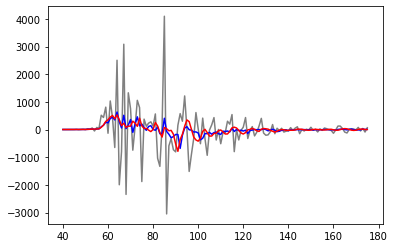

In [38]:
plt.plot('days', 'delta_new_cases', data=df[df['county'] == 'New York City'], color='gray')
plt.plot('days', 'delta_new_cases_7d', data=df[df['county'] == 'New York City'], color='blue')
plt.plot('days', 'new_cases_slope', data=df[df['county'] == 'New York City'], color='red')

In [ ]:
df6.to_csv('data/df-1.csv', index=False)

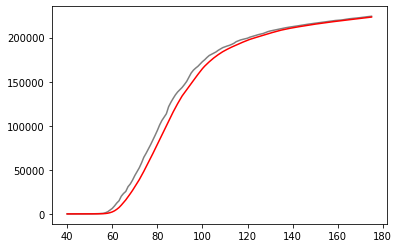

In [57]:
plt.plot('days', 'cases', data=df[df['county'] == 'New York City'], color='gray')
plt.plot('days', 'cases_7d', data=df[df['county'] == 'New York City'], color='red')

In [41]:
df[df['county'] == 'New York City']['new_cases_slope'].cumsum()

3798      0.000000
3799      0.000000
3800      0.000000
3801      0.000000
3802      0.000000
           ...    
3929    277.285714
3930    291.964286
3931    307.000000
3932    309.464286
3933    310.107143
Name: new_cases_slope, Length: 136, dtype: float64

In [ ]:
plt.plot('days', 'cases', data=df[df['county'] == 'New York City'], color='gray')